In [1]:
# Load Google Drive where data is stored, log in as required
from google.colab import drive
drive.mount('/content/drive')

# Clone the repo from Github to access the data
! git clone https://github.com/JesseCresswell/ML_demo.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'ML_demo' already exists and is not an empty directory.


In [0]:
# Import data from libSVM file format
from sklearn.datasets import load_svmlight_file

def get_data(file_name):
    data = load_svmlight_file(file_name)
    return data[0], data[1]

In [0]:
# Split data into features (x) and binary labels 0 or 1 (y)
train_x, train_y = get_data('/content/ML_demo/train.libsvm')
test_x, test_y = get_data('/content/ML_demo/valid.libsvm')

In [4]:
print("Dataset statistics: (number of examples, number of features)")
print("Training set:", train_x.shape)
print("Test set:", test_x.shape)
# Data is highly imbalanced. Train set had been downsampled
print('Training set: number of positive examples=%.0f' % train_y.sum())
print('Training set: imbalance ratio=%.4f' % (train_y.sum()/train_y.size))
print('Test set: number of positive examples=%.0f' % test_y.sum())
print('Test set: imbalance ratio=%.4f' % (test_y.sum()/train_y.size))
print("")
print("One example from Training set")
print(train_x[0, :])
print("Label:", train_y[0])
print("Features 0-29 not shown have value zero")

Dataset statistics: (number of examples, number of features)
Training set: (69060, 30)
Test set: (189128, 30)
Training set: number of positive examples=5172
Training set: imbalance ratio=0.0749
Test set: number of positive examples=516
Test set: imbalance ratio=0.0075

One example from Training set
  (0, 0)	1898.09998
  (0, 1)	2000.0
  (0, 2)	101.9
  (0, 4)	1.0
  (0, 17)	1.0
  (0, 19)	1.0
  (0, 26)	0.05095
  (0, 27)	54463.28906
  (0, 28)	1.0
  (0, 29)	121756.38281
Label: 0.0
Features 0-29 not shown have value zero


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


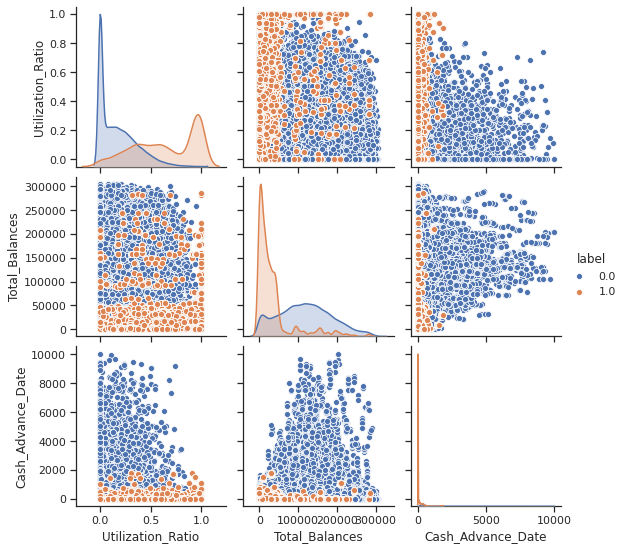

In [5]:
from matplotlib import pyplot
import pandas as pandas
import seaborn as seaborn; seaborn.set(style="ticks", color_codes=True)

# Load feature names
with open('/content/ML_demo/feature_names.txt') as file:
    content = file.readlines()
    features = [x.strip() for x in content]

dataframe = pandas.DataFrame(train_x.toarray(), columns=features)
dataframe['label'] = train_y
g = seaborn.pairplot(dataframe, hue="label", vars=['Utilization_Ratio', 'Total_Balances', 'Cash_Advance_Date'])

In [6]:
from sklearn.linear_model import LogisticRegression

# Train a classifier using logistic regression
logistic_classifier = LogisticRegression(random_state=0).fit(train_x, train_y)

print("Accuracy is not a good metric for unbalanced datasets")
print('Logistic: Mean Accuracy on train=%.3f' % logistic_classifier.score(train_x, train_y))
print('Logistic: Mean Accuracy on test=%.3f' % logistic_classifier.score(test_x, test_y))

# Define ROCAUC and PRAUC scores
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

def prauc(y, y_pred):
  prec, rec, _ = precision_recall_curve(y, y_pred)
  return auc(rec, prec)

# Outputs list of probabilities for class 0 and 1
l_train_probs_both_classes = logistic_classifier.predict_proba(train_x)
l_test_probs_both_classes = logistic_classifier.predict_proba(test_x)
# Take only probabilities for class 1 - the target
l_train_probs = l_train_probs_both_classes[:, 1]
l_test_probs = l_test_probs_both_classes[:, 1]

print("")
print("ROCAUC is the likelihood of correctly ranking two random examples from opposite classes")
print('Logistic: ROCAUC on train=%.3f' % (roc_auc_score(train_y, l_train_probs)))
print('Logistic: ROCAUC on test=%.3f' % (roc_auc_score(test_y, l_test_probs)))
print("")
print("PRAUC summarizes the trade off between precision and recall")
print('Logistic: PRAUC on train=%.3f' % (prauc(train_y, l_train_probs)))
print('Logistic: PRAUC on test=%.3f' % (prauc(test_y, l_test_probs)))

Accuracy is not a good metric for unbalanced datasets
Logistic: Mean Accuracy on train=0.949
Logistic: Mean Accuracy on test=0.993

ROCAUC is the likelihood of correctly ranking two random examples from opposite classes
Logistic: ROCAUC on train=0.923
Logistic: ROCAUC on test=0.934

PRAUC summarizes the trade off between precision and recall
Logistic: PRAUC on train=0.649
Logistic: PRAUC on test=0.135


Logistic: ROCAUC on test=0.934


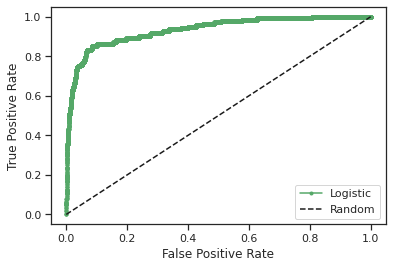

In [7]:
from sklearn.metrics import roc_curve

print('Logistic: ROCAUC on test=%.3f' % (roc_auc_score(test_y, l_test_probs)))
# Calculate ROC curve for Logistic Regression
logistic_fpr, logistic_tpr, _ = roc_curve(test_y, l_test_probs)

# Add a baseline - random guessing
random_probs = [0 for _ in range(len(test_y))]
random_fpr, random_tpr, _ = roc_curve(test_y, random_probs)

# Plot the ROC curve
pyplot.plot(logistic_fpr, logistic_tpr, marker='.', color='g', label='Logistic')
pyplot.plot(random_fpr, random_tpr, linestyle='--', color='k', label='Random')
# Define axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

Logistic: PRAUC on test=0.135
Baseline: PRAUC on test=0.003


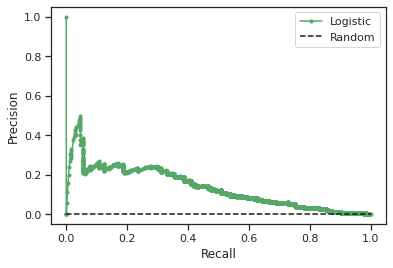

In [8]:
logistic_precision, logistic_recall, _ = precision_recall_curve(test_y, l_test_probs)

print('Logistic: PRAUC on test=%.3f' % (prauc(test_y, l_test_probs)))

# Plot the precision-recall curves
random = len(test_y[test_y==1]) / len(test_y)
print('Baseline: PRAUC on test=%.3f' % random)
pyplot.plot(logistic_recall, logistic_precision, marker='.', color='g', label='Logistic')
pyplot.plot([0, 1], [random, random], linestyle='--', color='k', label='Random')
# Define axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

In [9]:
import xgboost as xgb

# Load data files from Drive
# XGBoost uses the DMatrix data type, https://xgboost.readthedocs.io/en/latest/python/index.html
train_data = xgb.DMatrix('/content/ML_demo/train.libsvm', feature_names=features)
test_data = xgb.DMatrix('/content/ML_demo/valid.libsvm', feature_names=features)

[01:31:23] 69060x30 matrix with 676571 entries loaded from /content/ML_demo/train.libsvm
[01:31:23] 189128x30 matrix with 1870664 entries loaded from /content/ML_demo/valid.libsvm


In [10]:
# Define learning objective and basic parameters
param = {"booster": "gbtree", "tree_method": "exact", 'objective': 'binary:logistic', 'nthread': 4,
         'max_depth': 3, 'eta': 0.01,
         'eval_metric': ['auc','aucpr']}
# Number of trees to train in the ensemble
num_round = 3
# Choose metrics to display in training
evallist = [(test_data, 'eval'), (train_data, 'train')]

booster = xgb.train(param, train_data, num_round, evallist)

[0]	eval-auc:0.960748	eval-aucpr:0.398055	train-auc:0.954193	train-aucpr:0.754872
[1]	eval-auc:0.960748	eval-aucpr:0.398055	train-auc:0.954193	train-aucpr:0.754872
[2]	eval-auc:0.960748	eval-aucpr:0.398055	train-auc:0.954193	train-aucpr:0.754872


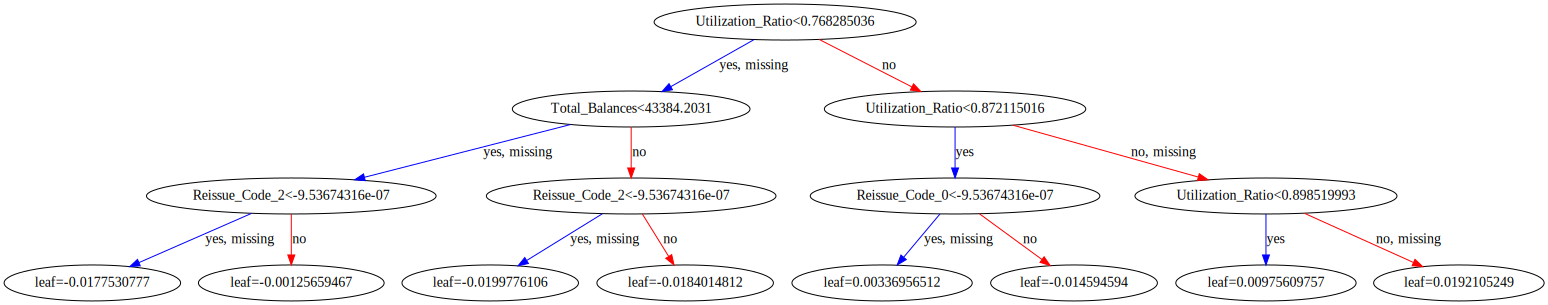

In [11]:
import graphviz, matplotlib
# Show the first decision tree in the ensemble
xgb.to_graphviz(booster)

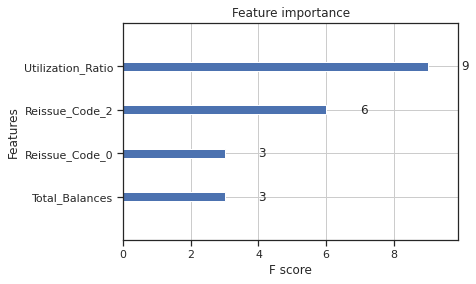

In [12]:
xgb.plot_importance(booster)

XGBoost: ROC AUC=0.961


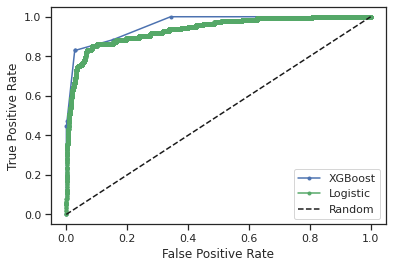

In [13]:
#Get predictions on test set
test_predictions = booster.predict(test_data)

# Calculate ROC curve for XGBoost output
xgboost_auc = roc_auc_score(test_data.get_label(), test_predictions)
print('XGBoost: ROC AUC=%.3f' % (xgboost_auc))
xgboost_fpr, xgboost_tpr, _ = roc_curve(test_data.get_label(), test_predictions)

# Plot the roc curve
pyplot.plot(xgboost_fpr, xgboost_tpr, color='b', marker='.', label='XGBoost')
pyplot.plot(logistic_fpr, logistic_tpr, color='g', marker='.', label='Logistic')
pyplot.plot(random_fpr, random_tpr, color='k', linestyle='--', label='Random')
# Define axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

XGBoost: PRAUC=0.484


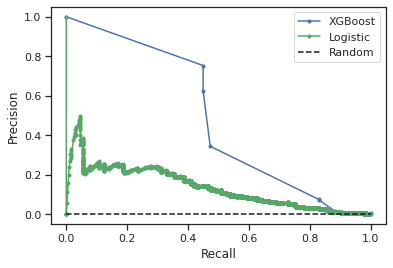

In [14]:
xgboost_precision, xgboost_recall, _ = precision_recall_curve(test_data.get_label(), test_predictions)
xgboost_auc = auc(xgboost_recall, xgboost_precision)
print('XGBoost: PRAUC=%.3f' % xgboost_auc)

# plot the precision-recall curves
pyplot.plot(xgboost_recall, xgboost_precision, color='b', marker='.', label='XGBoost')
pyplot.plot(logistic_recall, logistic_precision, color='g', marker='.', label='Logistic')
pyplot.plot([0, 1], [random, random], color = 'k', linestyle='--', label='Random')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [15]:
# Let's optimize the parameters a bit
# see the documentation https://xgboost.readthedocs.io/en/latest/parameter.html

param_2 = {"booster": "gbtree", "tree_method": "exact", 'objective': 'binary:logistic', 'nthread': 4,
         'max_depth': 4, 'eta': 0.02,
         "gamma": 1, "min_child_weight": 2, "colsample_bytree": 0.8,
         "base_score": 0.07, "scale_pos_weight": 1,
         'eval_metric': ['auc','aucpr']}

num_rounds_2 = 10
booster2 = xgb.train(param_2, train_data, num_rounds_2, evallist)

[0]	eval-auc:0.955141	eval-aucpr:0.096502	train-auc:0.953594	train-aucpr:0.653383
[1]	eval-auc:0.968294	eval-aucpr:0.362972	train-auc:0.964262	train-aucpr:0.775248
[2]	eval-auc:0.969537	eval-aucpr:0.404059	train-auc:0.966277	train-aucpr:0.791067
[3]	eval-auc:0.975649	eval-aucpr:0.464274	train-auc:0.967206	train-aucpr:0.800971
[4]	eval-auc:0.97623	eval-aucpr:0.472667	train-auc:0.969514	train-aucpr:0.804743
[5]	eval-auc:0.975051	eval-aucpr:0.474379	train-auc:0.970535	train-aucpr:0.806437
[6]	eval-auc:0.974667	eval-aucpr:0.49133	train-auc:0.970931	train-aucpr:0.807209
[7]	eval-auc:0.976352	eval-aucpr:0.497061	train-auc:0.970288	train-aucpr:0.807003
[8]	eval-auc:0.976669	eval-aucpr:0.499868	train-auc:0.970703	train-aucpr:0.807632
[9]	eval-auc:0.976666	eval-aucpr:0.501059	train-auc:0.970776	train-aucpr:0.808185


XGBoost: ROC AUC=0.977


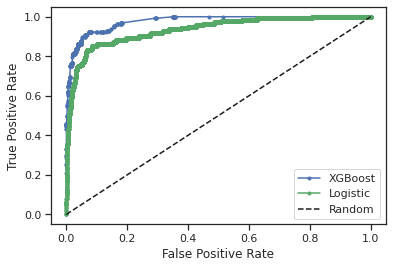

In [16]:
test_predictions_2 = booster2.predict(test_data)

xgboost_auc_2 = roc_auc_score(test_data.get_label(), test_predictions_2)
print('XGBoost: ROC AUC=%.3f' % (xgboost_auc_2))
# Calculate ROC curve for XGBoost output
xgboost_fpr_2, xgboost_tpr_2, _ = roc_curve(test_data.get_label(), test_predictions_2)

# Plot the roc curve
pyplot.plot(xgboost_fpr_2, xgboost_tpr_2, color='b', marker='.', label='XGBoost')
pyplot.plot(logistic_fpr, logistic_tpr, color='g', marker='.', label='Logistic')
pyplot.plot(random_fpr, random_tpr,color='k', linestyle='--', label='Random')
# Define axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

XGBoost: PRAUC=0.509


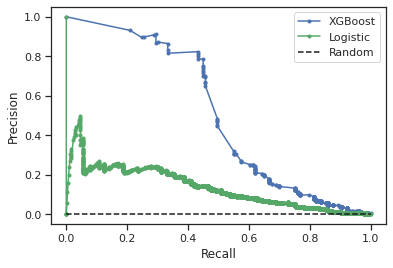

In [17]:
xgboost_precision_2, xgboost_recall_2, _ = precision_recall_curve(test_data.get_label(), test_predictions_2)
xgboost_prauc_2 = auc(xgboost_recall_2, xgboost_precision_2)
# Summarize scores
print('XGBoost: PRAUC=%.3f' % xgboost_prauc_2)
# Plot the precision-recall curves
pyplot.plot(xgboost_recall_2, xgboost_precision_2, color='b', marker='.', label='XGBoost')
pyplot.plot(logistic_recall, logistic_precision, color='g', marker='.', label='Logistic')
pyplot.plot([0, 1], [random, random], color='k', linestyle='--', label='Random')
# Define axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()